# Digital Musicology Project - Chord-based Characterization of Choruses and Verses in Pop and Rock Songs

# Research Question

# Presentation of the dataset

# Preprocessing of the songs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')
import plotly.express as px
import seaborn as sns
import researchpy as rp

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Parser for the songs</strong>
</div> 

In [2]:
SONG_ID, LINE_NUMBER, MEASURE_NUMBER, CHORD_NUMBER, SEQUENCE_NUMBER, \
CHORD, INSTRUMENT, TYPE, TIME, STRUCTURE, DURATION, REPETITION, ELID = \
"song_id","line_id", "measure_id", "chord_id", "sequence_id",\
"chord", "instrument", "section_type", "time", "section_structure", "duration", "repetition", "elided"

#This is dependant of "metre" in the txt files.
METRE = "metre"

#Create a new dictionary from two other
def immutable_merge(dic1, dic2):
    result = dic1.copy()
    result.update(dic2)
    return result

#Create a row of the futur df as a dictionary
def create_row(persistent_attributes, line_attributes,
               measure_number = None, chord_number = None, chord = None, duration = None):
    result = immutable_merge(persistent_attributes, line_attributes)
    
    if not (measure_number is None and measure_number is None and chord_number is None and duration is None):
        result[MEASURE_NUMBER] = measure_number
        result[CHORD_NUMBER] = chord_number
        result[CHORD] = chord
        result[DURATION] = duration
    
    return result

#Generate the attributes of a given line and update the sequence counter
def process_line_metadata(header, line_counter, old_line_attributes, sequence_counter, suffix = ""):
    
    result = {}
    
    #Suffix (main instrument, elid, repetition)
    old_instrument = str(old_line_attributes.get(INSTRUMENT))
    
    for suffix in suffix.split(", "):
        
        suffix = suffix.strip()
        
        #Repetition
        if re.match("^x\d+$",suffix):
            result[REPETITION] = int(suffix[1])
        
        #Elid
        elif suffix == "->":
            result[ELID] = True

        #Instrument
        else:
            ##New instrument
            if len(suffix) > 0 and suffix != "\n":
                result[INSTRUMENT] = suffix.strip("\n").strip(",").strip()

            ##Main instrument continued (experimental)
            elif not old_instrument.endswith(")") and old_instrument.lower() not in ["nan","none"] \
            and len(old_instrument)>0:
                result[INSTRUMENT] = old_instrument.strip("(")

        
    #Line number
    result[LINE_NUMBER] = line_counter

    
    #Header    
    header_items = header.split()
        
    result[TIME] = header_items[0]
    
    #Case where a section is continued
    if len(header_items) == 1:
        result[TYPE] = old_line_attributes.get(TYPE)
        result[STRUCTURE] = old_line_attributes.get(STRUCTURE)
        result[SEQUENCE_NUMBER] = old_line_attributes.get(SEQUENCE_NUMBER)
    
    #Case where a section has no structure (silence, end, fadeout)
    elif len(header_items) == 2:
        
        #Z is a structure, not a type.
        if header_items[1].strip().strip(",") == "Z":
            result[STRUCTURE] = header_items[1].strip().strip(",")
        else:
            result[TYPE] = header_items[1].strip().strip(",")
            
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    #Case where a section begins.
    elif len(header_items) == 3:
        result[STRUCTURE] = header_items[1].strip().strip(",")
        result[TYPE] = header_items[2].strip().strip(",")
        result[SEQUENCE_NUMBER] = sequence_counter
        sequence_counter += 1
    
    return sequence_counter, result

In [3]:
def parse_song_to_dict(song_id, path):
    
    rows = []
    persistent_attributes = {}
    
    persistent_attributes[SONG_ID] = song_id
    
    with open(path,"r") as file:
        line = file.readline()
        
        line_counter = 0
        measure_counter = 0
        chord_counter = 0
        sequence_counter = 0
        line_attributes = {}
        old_chord = None
 

        while line:
        
            if line != "\n":

                #Attribute lines
                if line.startswith("#"):
                    attribute, value = line.strip("#").split(":",1)
                    persistent_attributes[attribute.strip(" ")] = value.strip(" ").strip("\n")

                else:
                    line_items = line.split("|")

                    #Special lines
                    if len(line_items) <= 1:
                        sequence_counter, line_attributes = \
                        process_line_metadata(line, line_counter, line_attributes, sequence_counter)
                        row = create_row(persistent_attributes, line_attributes)
                        rows.append(row)

                    #Standard lines    
                    else:                    
                        header = line_items[0]
                        suffix = line_items[-1]
                        measures = line_items[1:-1]

                        sequence_counter, line_attributes = \
                        process_line_metadata(header, line_counter, line_attributes, sequence_counter, suffix)  

                        for measure in measures:
                            
                            chords = measure.split()
                            
                            #Special metric (experimental)
                            old_metre = persistent_attributes.get(METRE)
                            if re.match("^\(\d/\d\)$", chords[0]):
                                persistent_attributes[METRE] = str(chords[0][1]) + "/" + str(chords[0][3])
                                chords = chords[1:]
                            
                            if len(chords) == 1:
                                duration = "measure"
                            elif len(chords) == 2 and persistent_attributes[METRE] in ["4/4","12/8"]:
                                duration = "half-measure"
                            else:
                                duration = "beat"
                            
                            for chord in chords:
                                
                                if chord == ".":
                                    chord = old_chord
                                
                                row = create_row(persistent_attributes, line_attributes,
                                                 measure_counter, chord_counter, chord, duration)
                                rows.append(row)
                                old_chord = chord
                                chord_counter += 1

                            measure_counter += 1
                            persistent_attributes[METRE] = old_metre
            
            #Finally
            line_counter += 1
            line = file.readline()
    
    
    return rows

In [4]:
def create_whole_collection_df():
    
    path = "data/McGill-Billboard/"
    file_name = "/salami_chords.txt"
    UPPER_BOUND = 1300
    
    whole_collection = []
    
    i = 0
    while i <= UPPER_BOUND:
        full_path = path + "0"*(4-len(str(i)))+ str(i) + file_name
        
        if os.path.exists(full_path):
            whole_collection += parse_song_to_dict(i, full_path)
        
        i += 1
        
    whole_collection_df = pd.DataFrame(whole_collection)
    
    return whole_collection_df.astype({SEQUENCE_NUMBER: 'Int64', MEASURE_NUMBER: 'Int64', CHORD_NUMBER: 'Int64', \
                                      REPETITION: 'Int64'})

In [5]:
collection_df = create_whole_collection_df()

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Parser for the chords</strong>
</div> 

We also define a parser to better handle the chords. This is based on the notation defined in [SYMBOLIC REPRESENTATION OF MUSICAL CHORDS: A PROPOSED SYNTAX FOR TEXT ANNOTATIONS](http://ismir2005.ismir.net/proceedings/1080.pdf) by C. Harte, M. Sandler, S. Abdallah and E. Gomez. Some notations are also added by the authors of the dataset and therefore included to handle all the 978 unique chords in the dataset. 

In [6]:
print('There are %d unique chords in the dataset.' %len(collection_df.chord.unique()))

There are 978 unique chords in the dataset.


In [7]:
#Split a string and changes the target field depending on which side of the split to take
#side : 0 for left and 1 for right
def split_add(c,dic,split_char,target,side):
    temp=str.split(str(c),split_char)

    dic[target]=temp[side]
    return dic, temp[1-side]


def chord_to_tab(c):
    c=str(c)
    chord={"root":"", "shorthand" : "", "degree_list":[], "bass":"", "N" :False}
    rest=""
    
    if(c=="N"):
        chord["N"] = True
        return chord
    
    c=c.replace(")","")
    
    if('/' in c):
        chord, rest=split_add(c,dic=chord,split_char="/",target="bass",side=1)
    else :
        rest=c
    if(':' in rest):
        chord, rest=split_add(rest,dic=chord,split_char=":",target="root",side=0)
    if('(' in rest):
        chord, rest=split_add(rest,dic=chord,split_char="(",target="degree_list",side=1)
    if(rest != ""):
        chord["shorthand"]=rest
    
    return chord

    

In [8]:
collection_df['chord_dic'] = collection_df.chord.map(lambda y : chord_to_tab(y))
for key in ['root', 'shorthand', 'degree_list', 'bass', 'N']:
    collection_df[key] = collection_df.chord_dic.map(lambda y: y[key])
collection_df.drop(columns = 'chord_dic', inplace = True)
#df = collection_df[['song_id', 'title', 'artist', 'tonic', 'section_type', 'sequence_id', 'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N']]

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of new columns of relative-to-tonic roots</strong>
</div> 

In [9]:
TPC_DIC = {"Cb":11,"C":0,"C#":1,"Db":1,"D":2,"D#":3,"Eb":3,"E":4,"E#":5,"Fb":4,"F":5,"F#":6,
           "Gb":6,"G":7,"G#":8,"Ab":8,"A":9,"A#":10,"Bb":10,"B":11,"B#":0}

In [10]:
collection_df["root_tpc"] = collection_df.root.apply(lambda r : TPC_DIC.get(r))
collection_df = collection_df.astype({"root_tpc":"Int64"})

In [11]:
collection_df["relative_root_tpc"] =\
collection_df.apply(lambda row: (row["root_tpc"] - TPC_DIC.get(row["tonic"]))%12,axis = 1)

In [12]:
collection_df = collection_df.fillna({REPETITION:1})

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of the dataframe with only songs that have both a verse and a chorus</strong>
</div> 

In [13]:
valid_songs = collection_df[[SONG_ID,TYPE]].drop_duplicates().groupby(SONG_ID)[TYPE].apply(list)\
.apply(lambda l: "chorus" in l and "verse" in l)

In [14]:
d_collection_df = collection_df.merge(valid_songs.reset_index().rename(columns = {TYPE:"valid"}),on = SONG_ID)
d_collection_df = d_collection_df[d_collection_df.valid].drop(columns = 'valid')

In [15]:
print('The corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The corpus has 712 songs.



<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Dropping duplicates songs</strong>
</div>


In [16]:
ids_to_keep = d_collection_df[["song_id","title"]].drop_duplicates("title")["song_id"].values
d_collection_df = d_collection_df[d_collection_df.song_id.isin(ids_to_keep)]

In [17]:
print('The final corpus has %d songs.' %len(d_collection_df.song_id.unique()))

The final corpus has 585 songs.


<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Creation of a one-row-per-beat dataframe</strong>
</div> 

Duration of measure: all metre in the corpus are regular except song 700 (5/8 = 3 + 2). This was counted as two beats.

In [18]:
def weight_row(metre, duration, repetition):
    """
    Indicate to how many beats in total a chord described on a dataframe's row correspond.
    Careful ! The chords are non-successive in case of repetition
    """
    num, denom = metre.split("/")
    
    if metre == "5/8": #Specific to this dataset
        beat_per_measure = 2
    else:
        beat_per_measure = int(num)/(1 if int(denom) == 4 else 3)
    
    if duration == "measure":
        return beat_per_measure*(repetition)
    
    elif duration == "half-measure":
        return beat_per_measure/2*(repetition)
    
    elif duration == "beat":
        return repetition
    
    else:
        return 0

def successive_repetition_row(metre,duration):
    """
    Indicate on how many successive beats a chord is present
    """
    return weight_row(metre,duration,repetition=1)

In [19]:
# Creation of one-row-per-bit dataframe
N_SUCC_BEATS = "n_succ_beats"

d_collection_df[N_SUCC_BEATS] = d_collection_df.apply(\
    lambda row: successive_repetition_row(row[METRE], row[DURATION]),axis=1)
d_collection_df = d_collection_df.astype({N_SUCC_BEATS:"Int64"})

In [20]:
from tqdm import tqdm

def create_beats_df(d_collection_df):
    beats_dics = []
    repetition_flag = False
    repeted_dics = []
    repetition_line = np.PINF
    repetition_song = np.PINF
    for i in tqdm(d_collection_df.reset_index().index):

        if repetition_flag == True and\
(repetition_line != d_collection_df.iloc[i][LINE_NUMBER] or repetition_song != d_collection_df.iloc[i][SONG_ID]):

            for r in range(repetition_n):
                beats_dics += repeted_dics

            repetition_flag = False
            repeted_dics = []
            repetition_line = np.PINF
            repetition_song = np.PINF
        
        
        if d_collection_df.iloc[i][REPETITION] == 1 :

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                beats_dics.append(d_collection_df.iloc[i].to_dict())

        else:

            repetition_flag = True
            repetition_line = d_collection_df.iloc[i][LINE_NUMBER]
            repetition_song = d_collection_df.iloc[i][SONG_ID]
            repetition_n = d_collection_df.iloc[i][REPETITION]

            for b in range(d_collection_df.iloc[i][N_SUCC_BEATS]):
                repeted_dics.append(d_collection_df.iloc[i].to_dict())

    beats_collection_df = pd.DataFrame(beats_dics)
    
    return beats_collection_df

In [21]:
beats_collection_df = create_beats_df(d_collection_df)
beats_collection_df = beats_collection_df.drop(N_SUCC_BEATS,axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 87919/87919 [01:06<00:00, 1320.61it/s]


Let's add the relative chord (using the relative root tpc previously obtained, the shorthand and the bass note).

In [22]:
beats_collection_df['relative_chord'] = beats_collection_df['relative_root_tpc'].astype(str) + beats_collection_df['shorthand'] + beats_collection_df['bass']

We will create new aggregated features, where we only consider the relative-to-the-tonic root of the chord and whether it's a major or a minor chord (or another chord quality).

In [26]:
def LabelMinMajChord(chord):
    label = 'other'
    if 'min' in chord: #This will label minmaj7 as a minor chord
        label = 'min' 
    elif 'maj' in chord:
        label = 'maj'
    return label

In [27]:
beats_collection_df['agg_chord_label'] = beats_collection_df['relative_root_tpc'].astype(str) + beats_collection_df['shorthand'].map(lambda x: LabelMinMajChord(x))

In [28]:
beats_collection_df[['song_id', 'title', 'artist', 'metre', 'tonic', 'section_type', 'sequence_id', 
                     'chord', 'root', 'shorthand', 'degree_list', 'bass', 'N', 'root_tpc',
                     'relative_root_tpc', 'relative_chord', 'agg_chord_label']].sample(5)

,song_id,title,artist,metre,tonic,section_type,sequence_id,chord,root,shorthand,degree_list,bass,N,root_tpc,relative_root_tpc,relative_chord,agg_chord_label
163610,844,Burning Down The House,Talking Heads,4/4,D,instrumental,11.0,F:5,F,5,[],,False,5.0,3.0,3.05,3.0other
147952,762,Walk Like A Man,Grand Funk Railroad,4/4,E,solo,11.0,E:maj,E,maj,[],,False,4.0,0.0,0.0maj,0.0maj
110599,549,Double Shot (Of My Baby's Love),Swingin' Medallions,4/4,Ab,verse,6.0,F:min,F,min,[],,False,5.0,9.0,9.0min,9.0min
178625,946,I Second That Emotion,The Miracles,4/4,D,pre-chorus,7.0,D:maj,D,maj,[],,False,2.0,0.0,0.0maj,0.0maj
28396,148,Spirits In The Material World,The Police,4/4,A,verse,4.0,A:min/b3,A,min,[],b3,False,9.0,0.0,0.0minb3,0.0min


<div style="border:1px solid black; padding:10px 10px; background-color: #FFAEBC;">
    <strong>Conclusion:</strong> the final dataframe beats_collection_df has the following properties:
    <ul>
        <li>each row corresponds to a beat and thus to a chord played</li>
        <li>only songs with both a verse and a chorus are kept</li>
        <li>all elements of a chord (root, quality, degree list and bass note) are given</li>
    </ul>
</div>

<div style="border:1px solid black; padding:10px 10px; background-color: #A0E7E5; text-align: center; font-size:20px;"> 
    <strong>Squeeze function</strong>
</div> 

As a last processing step, we define a function to obtain a dataframe with all the chords of a song squeezed in its various sections (intro, first verse, chorus, second verse...). This will be helpful later in our analysis.

In [29]:
#The squeeze function returns a dataframe with all the chords of a song squeezed in a row dependent on a subgroup
# of the section type. Default is "none" and will not filter any type of songs.
#try subgroup="chorus" or subgroup="verse"

def compress(s) :
    return s.dropna().to_list()

def squeeze(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    df_local = df_local.groupby(["song_id","title"])\
                        [["chord", "root", "shorthand", "bass", "relative_root_tpc", "relative_chord", "agg_chord_label"]]\
                        .agg(compress).reset_index()
    
    return df_local

In [30]:
squeeze(beats_collection_df).head()

,song_id,title,chord,root,shorthand,bass,relative_root_tpc,relative_chord,agg_chord_label
0,4,You've got a Friend,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Db:maj/5, Db:...","[Ab, Ab, Ab, Ab, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , 5, 5, 5, 5, , , , , , , , , , , , , 5...","[0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj5, 5.0m...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj, 5.0ma..."
1,10,An Innocent Man,"[C:maj, C:maj, C:maj, C:maj, C:maj, C:maj, C:m...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0ma...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0ma..."
2,12,Lookin' for Love,"[E:min, E:min, E:min, E:min, F#:min, F#:min, F...","[E, E, E, E, F#, F#, F#, F#, G, G, G, G, A, A,...","[min, min, min, min, min, min, min, min, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...","[2.0min, 2.0min, 2.0min, 2.0min, 4.0min, 4.0mi...","[2.0min, 2.0min, 2.0min, 2.0min, 4.0min, 4.0mi..."
3,16,She Bop,"[A:min, A:min, A:min, A:min, A:min, A:min, A:m...","[A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, ...","[min, min, min, min, min, min, min, min, min, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0min, 0.0min, 0.0min, 0.0min, 0.0min, 0.0mi...","[0.0min, 0.0min, 0.0min, 0.0min, 0.0min, 0.0mi..."
4,18,Kiss On My List,"[C:maj, C:maj, G:maj/11, G:maj/11, A:min/b3, A...","[C, C, G, G, A, A, G, G, C, C, C, C, C, C, C, ...","[maj, maj, maj, maj, min, min, maj, maj, min7,...","[, , 11, 11, b3, b3, 11, 11, , , , , , , , , ,...","[0.0, 0.0, 7.0, 7.0, 9.0, 9.0, 7.0, 7.0, 0.0, ...","[0.0maj, 0.0maj, 7.0maj11, 7.0maj11, 9.0minb3,...","[0.0maj, 0.0maj, 7.0maj, 7.0maj, 9.0min, 9.0mi..."


In [31]:
#squeeze section allows you to squeeze the sections of songs
def squeeze_section(df,subgroup="none"):
    df_local=df
    if(subgroup!="none"):
        df_local=df[df["section_type"]==subgroup]
    
    df_local = df_local.groupby(["song_id","title","sequence_id","section_type"])\
                        [["chord", "root", "shorthand", "bass", "relative_root_tpc", "relative_chord", "agg_chord_label"]]\
                        .agg(compress).reset_index()
    df_local['sequence_id'] = df_local['song_id'].astype(str) + ":" + df_local['sequence_id'].astype(int).astype(str)
    
    return df_local

In [32]:
squeeze_section(beats_collection_df).head()

,song_id,title,sequence_id,section_type,chord,root,shorthand,bass,relative_root_tpc,relative_chord,agg_chord_label
0,4,You've got a Friend,4:1,intro,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Db:maj/5, Db:...","[Ab, Ab, Ab, Ab, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , 5, 5, 5, 5, , , , , , , , ]","[0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 0.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj5, 5.0m...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 5.0maj, 5.0ma..."
1,4,You've got a Friend,4:2,verse,"[F:min, F:min, F:min, F:min, C:7/5, C:7/5, C:7...","[F, F, F, F, C, C, C, C, F, F, C, C, F, C, F, ...","[min, min, min, min, 7, 7, 7, 7, min, min, 7, ...","[, , , , 5, 5, , , , , 5, 5, b3, 5, , , , , , ...","[9.0, 9.0, 9.0, 9.0, 4.0, 4.0, 4.0, 4.0, 9.0, ...","[9.0min, 9.0min, 9.0min, 9.0min, 4.075, 4.075,...","[9.0min, 9.0min, 9.0min, 9.0min, 4.0other, 4.0..."
2,4,You've got a Friend,4:3,pre-chorus,"[G:hdim7, G:hdim7, G:hdim7, G:hdim7, C:7, C:7,...","[G, G, G, G, C, C, C, C, F, F, C, C, F, C, F, ...","[hdim7, hdim7, hdim7, hdim7, 7, 7, 7, 7, min, ...","[, , , , , , , , , , 5, 5, b3, 5, , , , , , , ...","[11.0, 11.0, 11.0, 11.0, 4.0, 4.0, 4.0, 4.0, 9...","[11.0hdim7, 11.0hdim7, 11.0hdim7, 11.0hdim7, 4...","[11.0other, 11.0other, 11.0other, 11.0other, 4..."
3,4,You've got a Friend,4:4,chorus,"[Ab:maj, Ab:maj, Ab:maj, Ab:maj, Ab:7, Ab:7, A...","[Ab, Ab, Ab, Ab, Ab, Ab, Ab, Ab, Db, Db, Db, D...","[maj, maj, maj, maj, 7, 7, 7, 7, maj, maj, maj...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, ...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.07, 0.07, 0...","[0.0maj, 0.0maj, 0.0maj, 0.0maj, 0.0other, 0.0..."
4,4,You've got a Friend,4:5,bridge,"[Gb:maj(9), Gb:maj(9), Gb:maj(9), Gb:maj(9), D...","[Gb, Gb, Gb, Gb, Db, Db, Db, Db, Ab, Ab, Ab, A...","[maj, maj, maj, maj, maj, maj, maj, maj, maj, ...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[10.0, 10.0, 10.0, 10.0, 5.0, 5.0, 5.0, 5.0, 0...","[10.0maj, 10.0maj, 10.0maj, 10.0maj, 5.0maj, 5...","[10.0maj, 10.0maj, 10.0maj, 10.0maj, 5.0maj, 5..."


# Analysis

## Dimensionality Reduction - Is it Possible to Distinguish Verses and Choruses in Low-Dimensional Spaces?

### Bag of Words Representation

In [33]:
vocab_absolute = dict.fromkeys(beats_collection_df.chord.unique(), 0) 
vocab_relative = dict.fromkeys(beats_collection_df.relative_chord.unique(), 0) 

Let's remove the non-chords elements.

In [34]:
for non_chord in ['', '&pause', 'nan', 'nan*']:
    vocab_absolute.pop(non_chord, None)
    vocab_relative.pop(non_chord, None)

In [35]:
def createBOW(chord_list, vocab):
    '''
    This function take a list of "words" and return the corresponding Bag of Words, using the provided vocabulary.
    '''
    bow = dict.fromkeys(vocab.keys(), 0)
    for chord in chord_list:
        if chord in bow.keys():
            bow[chord] += 1
    #Normalise the BoW to get a distribution
    total = sum(bow.values())
    if total != 0:
        bow = {chord: count/total for chord, count in bow.items()}
    return bow

In [36]:
def createBOW_df_section(df, section, vocab, chord):
    '''
    This function takes a dataframe containing all the chords of the songs and computes the BoW for each concatenated section 
    of the specified type using the given vocabulary. 
    The parameter "chord" allows to select the type of "words" to be used for the BoW.
    '''
    df_squeezed = squeeze(df, section)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.song_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['song_id'] = df_squeezed.song_id.unique()    
    
    return data[["song_id"] + list(vocab.keys())]

In [37]:
def createBOW_df_individual_sequence(df, section, vocab, chord):
    '''
    This function takes a dataframe containing all the chords of the songs and computes the BoW for each individual section 
    of the specified type using the given vocabulary. 
    The parameter "chord" allows to select the type of "words" to be used for the BoW.
    '''
    df_squeezed = squeeze_section(df, section)
    bow_dict = createBOW(df_squeezed[chord].iloc[0], vocab)
    data = pd.DataFrame(bow_dict, index = [0])
    for i in range(1, len(df_squeezed.sequence_id.unique())):
        bow_dict = createBOW(df_squeezed[chord].iloc[i], vocab)
        data = data.append(pd.DataFrame(bow_dict, index = [i]))
    data['sequence_id'] = df_squeezed.sequence_id    
    
    return data[["sequence_id"] + list(vocab.keys())]

First, we create the bow representation of whole songs or all chords corresponding to the given section, in absolute tpc.

In [38]:
df_bow_verse = createBOW_df_section(df = beats_collection_df, 
                                    vocab = vocab_absolute,
                                    section = "verse",
                                    chord = "chord")
df_bow_chorus = createBOW_df_section(df = beats_collection_df, 
                                     vocab = vocab_absolute,
                                     section = "chorus", 
                                     chord = "chord")

Then the same in relative to the tonic tpc.

In [39]:
df_bow_verse_rel = createBOW_df_section(df = beats_collection_df, 
                                        section = "verse", 
                                        vocab = vocab_relative, 
                                        chord = "relative_chord")
df_bow_chorus_rel = createBOW_df_section(df = beats_collection_df, 
                                         section = "chorus", 
                                         vocab = vocab_relative, 
                                         chord = "relative_chord")

And finally we create the bow representation for individual sections (meaning a song with two verses will give two distict verse sections). Here as well we use the relative to the tonic tpc.

In [40]:
df_bow_chorus_rel_seq = createBOW_df_individual_sequence(df = beats_collection_df, 
                                                         section = "chorus", 
                                                         vocab = vocab_relative, 
                                                         chord = "relative_chord")
df_bow_verse_rel_seq = createBOW_df_individual_sequence(df = beats_collection_df, 
                                                        section = "verse", 
                                                        vocab = vocab_relative, 
                                                        chord = "relative_chord")

#### Considerations on whether to consider each section individually or grouped together by song

In [41]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine

In [42]:
df_bow_chorus_rel_seq['song_id'] = df_bow_chorus_rel_seq['sequence_id'].map(lambda x: int(x.split(':')[0]))
df_bow_verse_rel_seq['song_id'] = df_bow_verse_rel_seq['sequence_id'].map(lambda x: int(x.split(':')[0]))

In [68]:
def ComputeDifferences_MeanBoWSection_BoWSong(df1, df2, vocab, section):
    '''
    This function computes the differences between the mean BoW of each section of a song taken individually 
    and the BoW of the song when concatening all the sequences of the given section type.
    '''
    diff = (df1.groupby('song_id').mean().reset_index()[vocab.keys()] - df2[vocab.keys()]).mean()
    plt.figure(figsize = (14,4))
    diff.plot(kind = 'hist', bins = 100, fontsize = 14)
    title = 'Distribution of the differences between \n the mean BoW of each section of a song and the BoW of the song (' + section + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Difference', fontsize = 18)
    plt.ylabel('Number of songs', fontsize = 18)
    plt.show()
    
    print("Statistics:")
    print(rp.summary_cont(diff))

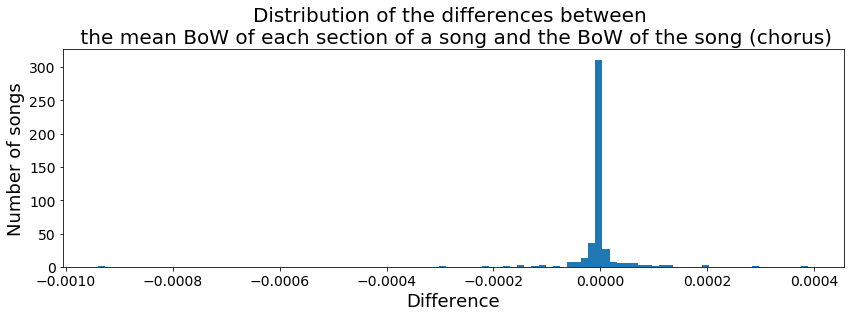

Statistics:


   Variable      N      Mean        SD        SE  95% Conf.  Interval
0       NaN  444.0 -0.000002  0.000061  0.000003  -0.000008  0.000004


In [69]:
ComputeDifferences_MeanBoWSection_BoWSong(df1 = df_bow_chorus_rel_seq, 
                                          df2 = df_bow_chorus_rel, 
                                          vocab = vocab_relative, 
                                          section = "chorus")

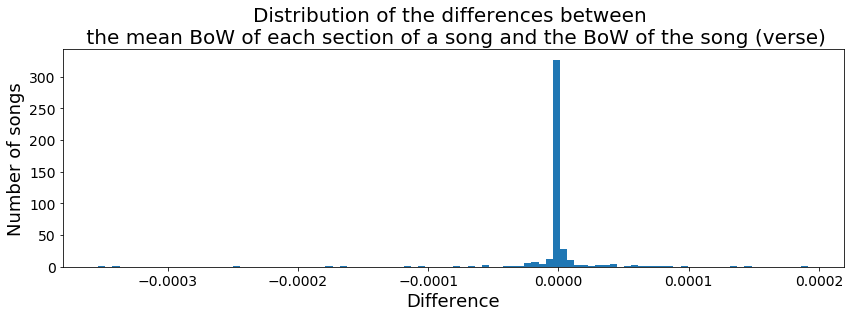

Statistics:


   Variable      N          Mean        SD        SE  95% Conf.  Interval
0       NaN  444.0 -9.625010e-07  0.000036  0.000002  -0.000004  0.000002


In [70]:
ComputeDifferences_MeanBoWSection_BoWSong(df1 = df_bow_verse_rel_seq, 
                                          df2 = df_bow_verse_rel, 
                                          vocab = vocab_relative, 
                                          section = "verse")

In [71]:
def ComputeCosineDistances_BoWSection_FullBoW(df1, df2, vocab, section):
    '''
    This function computes the cosine distances between the BoW of each section of a song taken individually 
    and the BoW of the song when concatening all the sequences of the given section type.
    '''
    diff = []
    for seq_id in df1.sequence_id.unique():
        diff.append(cosine(df1[df1.sequence_id == seq_id][vocab.keys()].squeeze(),
                           df2[df2.song_id == int(seq_id.split(':')[0])][vocab].squeeze()))
    plt.figure(figsize = (14,4))
    plt.hist(diff, bins = 100)
    title = 'Distribution of the cosine distances between \n the BoW of each section of a song and the full BoW of the song (' + section + ')'
    plt.title(title, fontsize = 20)
    plt.xlabel('Cosine Distance', fontsize = 18)
    plt.ylabel('Number of \n Individual Section / Full Song Pairs', fontsize = 18)
    plt.show()
    
    print("Statistics:")
    print(rp.summary_cont(pd.Series(diff)))

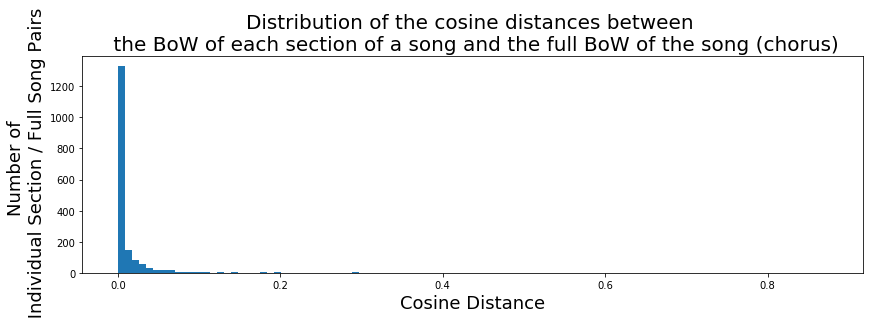

Statistics:


   Variable       N      Mean        SD        SE  95% Conf.  Interval
0       NaN  1887.0  0.028152  0.086602  0.001994   0.024242  0.032062


In [74]:
ComputeCosineDistances_BoWSection_FullBoW(df1 = df_bow_chorus_rel_seq, 
                                          df2 = df_bow_chorus_rel, 
                                          vocab = vocab_relative, 
                                          section = "chorus")

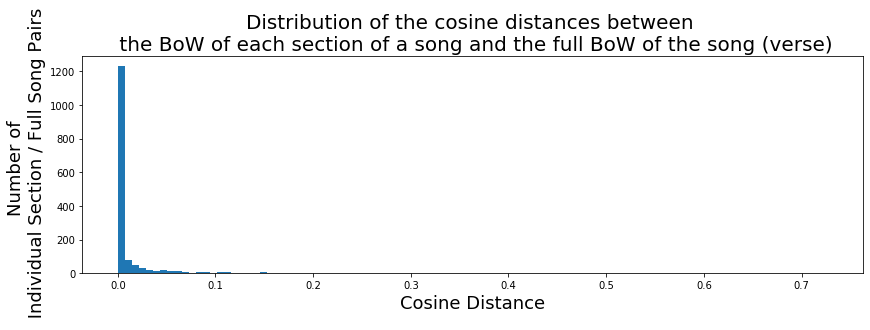

Statistics:


   Variable       N      Mean        SD        SE  95% Conf.  Interval
0       NaN  1586.0  0.019987  0.073937  0.001857   0.016346  0.023629


In [73]:
ComputeCosineDistances_BoWSection_FullBoW(df1 = df_bow_verse_rel_seq, 
                                          df2 = df_bow_verse_rel, 
                                          vocab = vocab_relative, 
                                          section = "verse")

#### Aggregated features

In [75]:
def PlotAggregatedFeaturesCount(section = None):
    plt.figure(figsize = (14,4))
    if section:
        beats_collection_df[beats_collection_df.section_type == section]['agg_chord_label'].value_counts().plot(kind = 'bar')
        title = 'Number of chords for the new aggregated features on all the ' + section
    else:
        beats_collection_df['agg_chord_label'].value_counts().plot(kind = 'bar')
        title = 'Number of chords for the new aggregated features on the whole corpus'
    plt.title(title, fontsize = 20)
    plt.xlabel('Aggregated feature', fontsize = 18)
    plt.xticks(rotation = 45)
    plt.ylabel('Number of chords', fontsize = 18)
    plt.show()

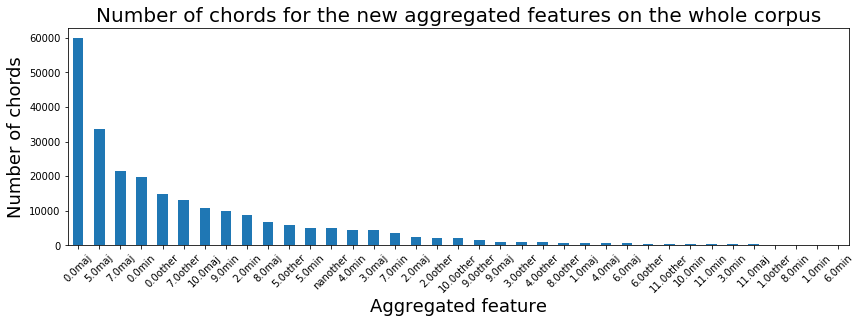

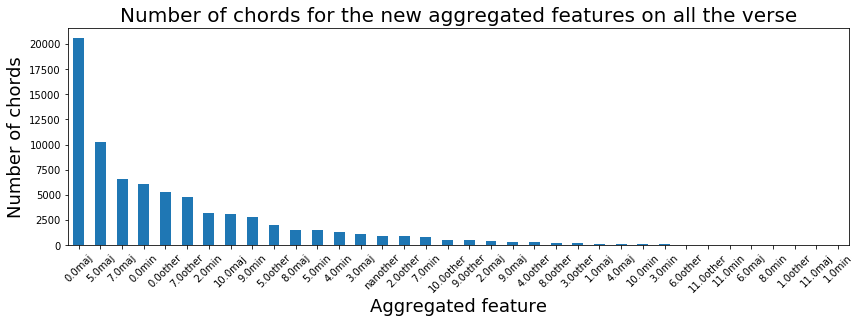

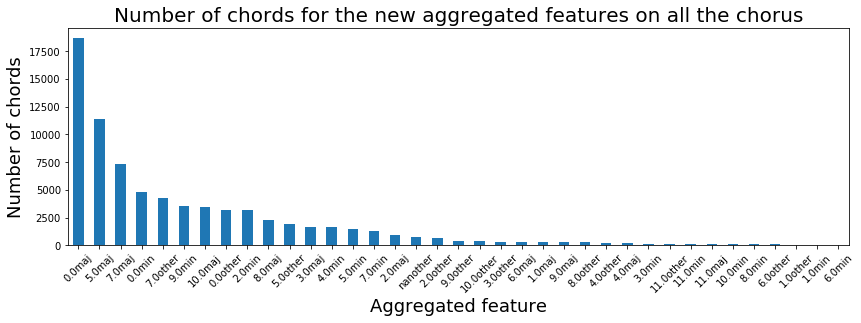

In [76]:
for section in [None, 'verse', 'chorus']:
    PlotAggregatedFeaturesCount(section)

We still need to remove the chord starting with nan.

In [77]:
features_agg = beats_collection_df.agg_chord_label.unique()
features_agg = np.delete(features_agg, 13)
features_agg = dict.fromkeys(features_agg, 0)

In [78]:
print('There are %d aggregated features.' %len(features_agg.keys()))

There are 36 aggregated features.


We can now create the new BoW representations for the verses and the choruses using the new aggregated features.

In [79]:
df_bow_verse_agg = createBOW_df_section(beats_collection_df, section = 'verse', vocab = features_agg, chord = 'agg_chord_label')
df_bow_chorus_agg = createBOW_df_section(beats_collection_df, section = 'chorus', vocab = features_agg, chord = 'agg_chord_label')

### Dimensionality Reductions Method

Dimensionality reduction is the process of reducing the number of features needed to represent a dataset, thus reducing the dimensionality of the space in which the dataset lies. This can be used either to find features that explain the data better or even to reduce the dimension low-enough so that it can be represented (thus on a 2D or 3D plot).

There are various methods to do so and in this project we rely on three of them: 
* Principal Component Analysis (PCA)
* Independent Component Analysis (ICA)
* t-distributed Stochastic Neighbor Embedding (tSNE)

In this section we will first explain these three methods and present the functions used to train the model and plot the results. Some utilitu functions to better investigate the results are also presented.

We will use the scikit-learn Python library, presented by [Scikit-learn: Machine Learning in Python](http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html), Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

We define a few absolute constants to homogenize the plots for the dimensionality reduction methods. 

In [231]:
ALPHA = 0.2
FIGSIZE = (6,6)
TITLE_FS = 18
AX_LABEL_FS = 16

#### Principal Component Analysis (PCA)

Perhaps the most used dimensionality reduction method, PCA performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. This ensures that the Principal Components obtained best explain the data since they explain most of its variance.

From a mathematical point of view, the transformation from the high-dimensional space to the lower-dimensional space is defined by a set of vectors $\vec{w}_{(k)}$ that map linearly each data sample $\vec{x}_{(i)}$ to a Principal Component $\vec{t}_{(i)}$ given by $t_{k(i)} = \vec{x}_{(i)} \cdot \vec{w}_{(k)}$. The weights $\vec{w}_{(k)}$ are iteratively obtained by maximizing the variance $\sum_{i} (\vec{t}_{(i)})^2 = \sum_{i} (\vec{x}_{(i)} \cdot \vec{w}_{(k)})^2$.

The [scikit-learn implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) presents in details all the parameters. The important ones here are:
* the number of components n_components (either an integer value specifying the number of Principal Components wanted or a float number specifying the amount of variance that we want to explain)
* the svd_solver used for the Singular Value Decomposition
* the random_state (in this case, the seed used by the random number generator)

In [232]:
from sklearn.decomposition import PCA

In [233]:
def PCA_visualization(df_verse, df_chorus, vocab, n_comps):
    '''
    This function train the PCA model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The number of Principal Components we want is specified.
    Once the model is trained, the PCs are plotted in 2D, coloring the verses in red and the choruses in blue.
    '''
    #Train the pca model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    pca_model = PCA(n_components = n_comps, svd_solver = "full", random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = pca_model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['PC1', 'PC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['PC1'], 
                principalDf[principalDf.label == 0]['PC2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['PC1'], 
                principalDf[principalDf.label == 1]['PC2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', #components: 2)'
    title = 'PCA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('PC1', fontsize = AX_LABEL_FS)
    plt.ylabel('PC2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()
    
    return pca_model

In [234]:
def PCA_explainedVariance(df_verse, df_chorus, vocab, prop_variance, num_PCs):
    '''
    This function aims at finding the number of PCs to explain a given proportion of variance 
    and also print the explained variance for the first num_PCs components.
    '''
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    pca_model = PCA(n_components = prop_variance,
                    svd_solver = "full", 
                    random_state = 42)
    pca_model.fit(X)
    print('The mininum number of PCs to explain %0.2f%% of the variance is %d.' % (100 * prop_variance, pca_model.n_components_))
    for (pc_i, var_ratio) in enumerate(pca_model.explained_variance_ratio_[:num_PCs]):
        print('The PC%d explains %0.2f%% of the total variance.' % (pc_i + 1, 100 * var_ratio))

In [268]:
def InspectWeightVector(weights, pc, features, n_weights, model_name):
    '''
    This function helps investigate the weights vectors w output by the model (used both for PCA and for ICA).
    It plots in a barplot the top n_weights elements from the sorted weight vector elements, 
    where each weight vector corresponds to a given feature of the data in the high-dimensional space.
    '''
    pc_id = pc - 1
    top_positive_weights = pd.DataFrame(columns = features, data = weights)\
                                                .iloc[pc_id].sort_values(ascending = False)[:n_weights]
    top_negative_weights = pd.DataFrame(columns = features, data = weights)\
                                                .iloc[pc_id].sort_values(ascending = True)[:n_weights].sort_values(ascending = False)
    plt.figure(figsize = (10,3))
    plt.bar(x = range(n_weights), height = top_positive_weights)
    plt.bar(x = range(-n_weights, 0), height = top_negative_weights)
    plt.xticks(range(-n_weights, n_weights), top_negative_weights.index.append(top_positive_weights.index), rotation = 30)
    title = 'Importance of each feature in Comp' + str(pc) + '\n of the ' + model_name + ' model (top ' + str(n_weights) + ')'
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Feature', fontsize = AX_LABEL_FS)
    plt.ylabel('Importance of the Feature', fontsize = AX_LABEL_FS)
    plt.grid(True, alpha = 0.5)
    plt.show()

#### Independent Component Analysis (ICA)

In [236]:
from sklearn.decomposition import FastICA

In [288]:
def FastICA_visualization(df_verse, df_chorus, vocab, n_comps):
    '''
    This function train the ICA model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The number of Independent Components we want is specified.
    Once the model is trained, the ICs are plotted in 2D, coloring the verses in red and the choruses in blue.
    '''
    #Train the FastICA model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    ica_model = FastICA(n_components = n_comps, random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = ica_model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['IC1', 'IC2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['IC1'], 
                principalDf[principalDf.label == 0]['IC2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['IC1'], 
                principalDf[principalDf.label == 1]['IC2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', #components: 2)'
    title = 'ICA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('IC1', fontsize = AX_LABEL_FS)
    plt.ylabel('IC2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()
    
    return ica_model

#### t-distributed Stochastic Neighbor Embedding (tSNE)

In [238]:
from sklearn.manifold import TSNE

In [239]:
def TSNE_visualization(df_verse, df_chorus, vocab, perplexity):
    '''
    This function train the tSNE model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The perplexity we want is specified.
    Once the model is trained, the data projected in the lower-dimensional space is plotted in 2D, 
    coloring the verses in red and the choruses in blue.
    '''
    #Train the tSNE model
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    model = TSNE(n_components = 2, verbose = 0, perplexity = perplexity, random_state = 42)
    
    #Get the principalComponents by fitting the model and transforming the input 
    principalComponents = model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y
    
    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    #Title of the plot
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + ', perp: ' + str(perplexity) + ')'
    title = 'tSNE on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Comp1', fontsize = AX_LABEL_FS)
    plt.ylabel('Comp2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()

#### TSNE initialized with PCA

In [240]:
def TSNE_PCAinit(df_verse, df_chorus, vocab, pca_comps, perplexity):
    '''
    This function train the tSNE model with a verse and chorus BoW representations dataframe and a given vocabulary.
    The perplexity we want is specified.
    However this time the model is initialized with the output of a PCA model with the given number pca_comps of PCs.
    Once the model is trained, the data projected in the lower-dimensional space is plotted in 2D, 
    coloring the verses in red and the choruses in blue.
    '''
    ##Create PCA input
    features = vocab.keys()
    X = np.concatenate((df_verse.loc[:, features].values, df_chorus.loc[:, features].values))
    y = np.concatenate((np.zeros(len(df_verse)), np.ones(len(df_chorus))))
    pca_model = PCA(n_components = pca_comps, random_state = 42)
    pca_result = pca_model.fit_transform(X)

    ##TSNE initialized with PCA
    tsne_model = TSNE(n_components = 2, verbose = 0, perplexity = perplexity, random_state = 42)
    tsne_pca_results = tsne_model.fit_transform(pca_result)

    principalDf = pd.DataFrame(data = tsne_pca_results[:,:2], columns = ['Comp1', 'Comp2'])
    principalDf['label'] = y

    #Plot the transformed input in the low-dimensional (2d) space, coloring the two sections to differentiate them
    plt.figure(figsize = FIGSIZE)
    plt.scatter(principalDf[principalDf.label == 0]['Comp1'], 
                principalDf[principalDf.label == 0]['Comp2'], 
                c = 'red', 
                alpha = ALPHA,
                label = 'Verse')
    plt.scatter(principalDf[principalDf.label == 1]['Comp1'], 
                principalDf[principalDf.label == 1]['Comp2'], 
                c = 'blue', 
                alpha = ALPHA,
                label = 'Chorus')
    settings = '(#features: ' + str(len(features)) + ', #samples: ' + str(len(X)) + \
               ', \n #PCA_components = ' + str(pca_comps) + ', perp: ' + str(perplexity) + ')'
    title = 'TSNE initialized with PCA on the verses and choruses \n' + settings
    plt.title(title, fontsize = TITLE_FS)
    plt.xlabel('Comp1', fontsize = AX_LABEL_FS)
    plt.ylabel('Comp2', fontsize = AX_LABEL_FS)
    plt.legend(fontsize = AX_LABEL_FS)
    plt.show()

### Application of the methods on the various BoW representations

#### BoW with the concatenated sections and the absolute chords

In [241]:
PCA_explainedVariance(df_verse = df_bow_verse,
                      df_chorus = df_bow_chorus,
                      vocab = vocab_absolute, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 85.
The PC1 explains 10.35% of the total variance.
The PC2 explains 9.51% of the total variance.
The PC3 explains 6.49% of the total variance.
The PC4 explains 4.83% of the total variance.
The PC5 explains 3.92% of the total variance.
The PC6 explains 3.58% of the total variance.
The PC7 explains 3.35% of the total variance.
The PC8 explains 2.65% of the total variance.
The PC9 explains 2.60% of the total variance.
The PC10 explains 2.05% of the total variance.


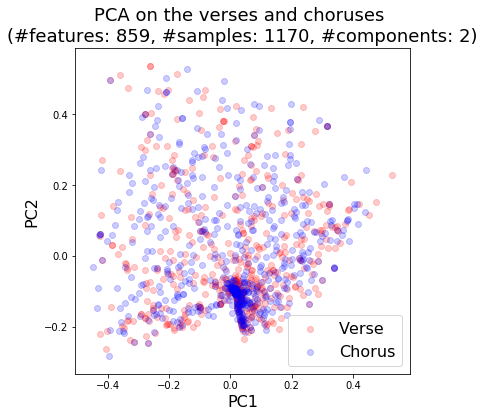

In [242]:
model_pca = PCA_visualization(df_verse = df_bow_verse,
                              df_chorus = df_bow_chorus,
                              vocab = vocab_absolute, 
                              n_comps = 2)

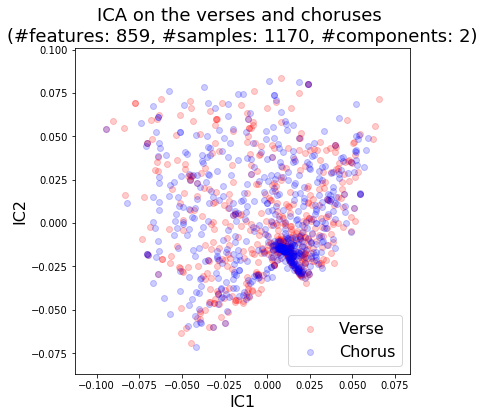

In [289]:
model_ica = FastICA_visualization(df_verse = df_bow_verse,
                                  df_chorus = df_bow_chorus,
                                  vocab = vocab_absolute, 
                                  n_comps = 2)

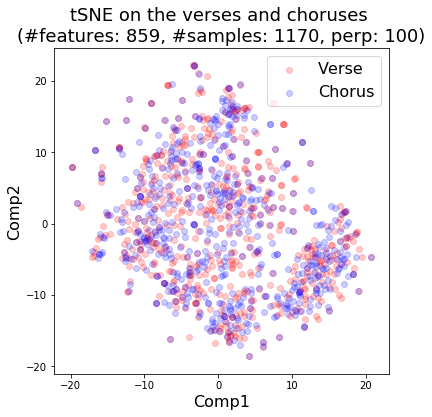

In [244]:
TSNE_visualization(df_verse = df_bow_verse, 
                   df_chorus = df_bow_chorus, 
                   vocab = vocab_absolute,  
                   perplexity = 100)

#### BoW with the concatenated sections and the relative chords

In [245]:
PCA_explainedVariance(df_verse = df_bow_verse_rel,
                      df_chorus = df_bow_chorus_rel,
                      vocab = vocab_relative, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 39.
The PC1 explains 23.85% of the total variance.
The PC2 explains 9.43% of the total variance.
The PC3 explains 8.41% of the total variance.
The PC4 explains 6.31% of the total variance.
The PC5 explains 5.79% of the total variance.
The PC6 explains 4.67% of the total variance.
The PC7 explains 3.58% of the total variance.
The PC8 explains 2.97% of the total variance.
The PC9 explains 2.66% of the total variance.
The PC10 explains 1.94% of the total variance.


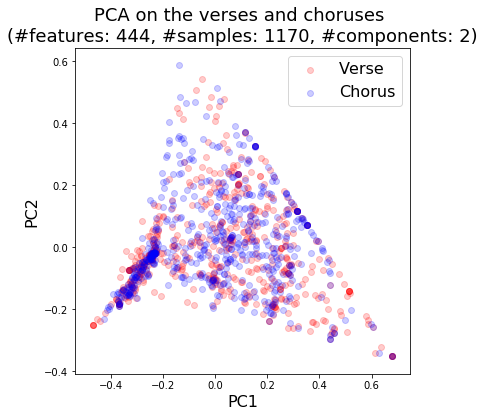

In [246]:
model_pca = PCA_visualization(df_verse = df_bow_verse_rel,
                              df_chorus = df_bow_chorus_rel,
                              vocab = vocab_relative, 
                              n_comps = 2)

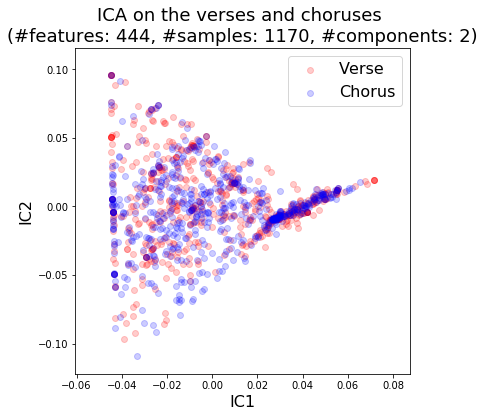

In [290]:
model_ica = FastICA_visualization(df_verse = df_bow_verse_rel,
                                  df_chorus = df_bow_chorus_rel,
                                  vocab = vocab_relative, 
                                  n_comps = 2)

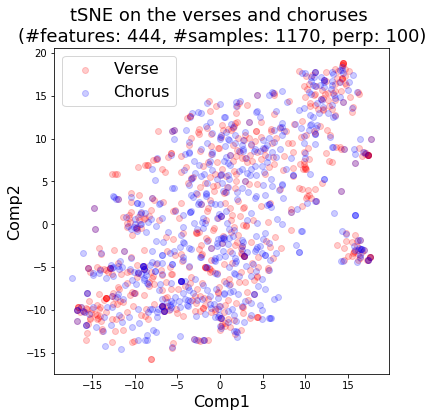

In [248]:
TSNE_visualization(df_verse = df_bow_verse_rel, 
                   df_chorus = df_bow_chorus_rel, 
                   vocab = vocab_relative,  
                   perplexity = 100)

#### BoW with the individual sections and the relative chords

In [249]:
PCA_explainedVariance(df_verse = df_bow_verse_rel_seq,
                      df_chorus = df_bow_chorus_rel_seq,
                      vocab = vocab_relative, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 40.
The PC1 explains 23.38% of the total variance.
The PC2 explains 9.33% of the total variance.
The PC3 explains 8.19% of the total variance.
The PC4 explains 6.25% of the total variance.
The PC5 explains 5.64% of the total variance.
The PC6 explains 4.51% of the total variance.
The PC7 explains 3.47% of the total variance.
The PC8 explains 2.75% of the total variance.
The PC9 explains 2.59% of the total variance.
The PC10 explains 2.07% of the total variance.


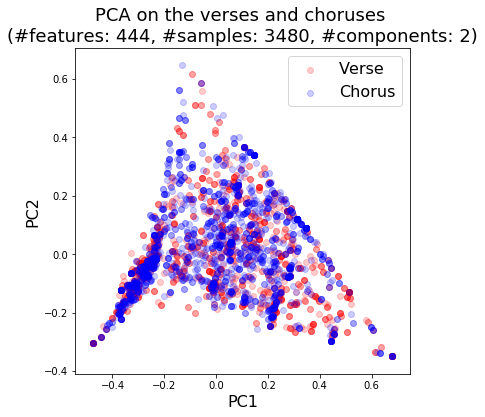

In [250]:
model_pca = PCA_visualization(df_verse = df_bow_verse_rel_seq,
                              df_chorus = df_bow_chorus_rel_seq,
                              vocab = vocab_relative, 
                              n_comps = 2)

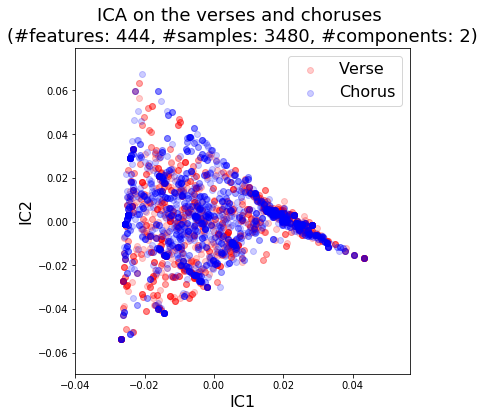

In [291]:
model_ica = FastICA_visualization(df_verse = df_bow_verse_rel_seq,
                                  df_chorus = df_bow_chorus_rel_seq,
                                  vocab = vocab_relative, 
                                  n_comps = 2)

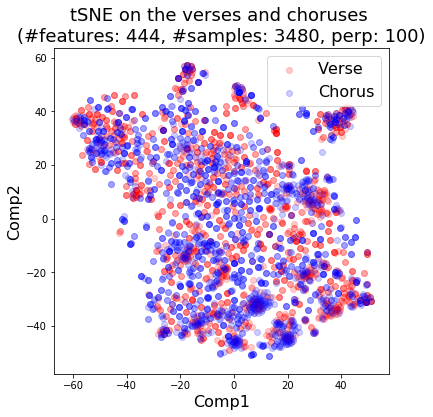

In [252]:
TSNE_visualization(df_verse = df_bow_verse_rel_seq, 
                   df_chorus = df_bow_chorus_rel_seq, 
                   vocab = vocab_relative,  
                   perplexity = 100)

#### BoW with the individual sections and the features aggregated

In [253]:
PCA_explainedVariance(df_verse = df_bow_verse_agg,
                      df_chorus = df_bow_chorus_agg,
                      vocab = features_agg, 
                      prop_variance = 0.9,
                      num_PCs = 10)

The mininum number of PCs to explain 90.00% of the variance is 11.
The PC1 explains 29.25% of the total variance.
The PC2 explains 14.43% of the total variance.
The PC3 explains 11.43% of the total variance.
The PC4 explains 7.55% of the total variance.
The PC5 explains 7.06% of the total variance.
The PC6 explains 5.51% of the total variance.
The PC7 explains 4.19% of the total variance.
The PC8 explains 3.44% of the total variance.
The PC9 explains 2.97% of the total variance.
The PC10 explains 2.69% of the total variance.


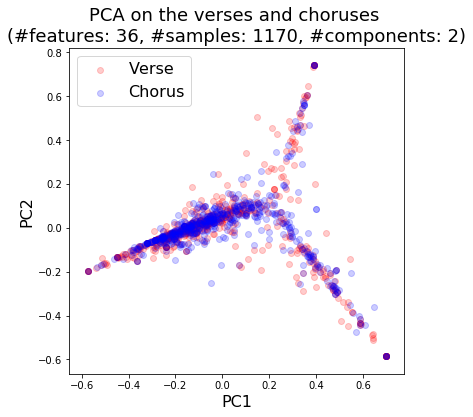

In [266]:
model_pca = PCA_visualization(df_verse = df_bow_verse_agg,
                              df_chorus = df_bow_chorus_agg,
                              vocab = features_agg, 
                              n_comps = 11)

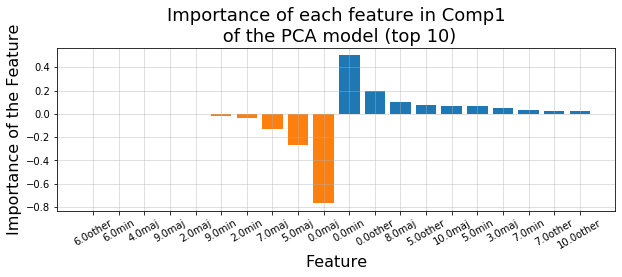

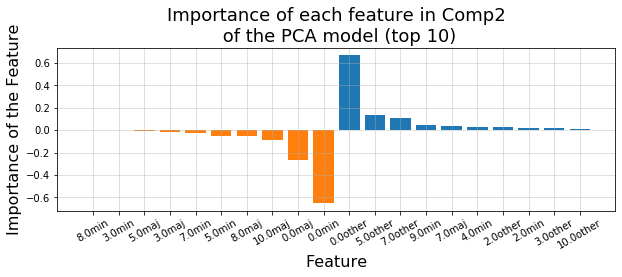

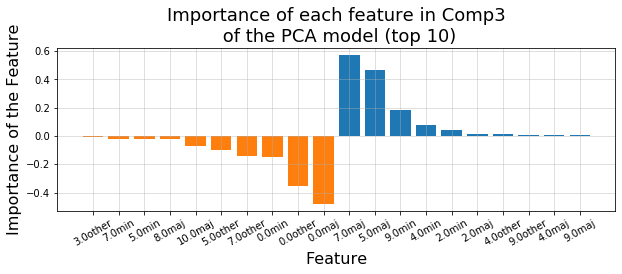

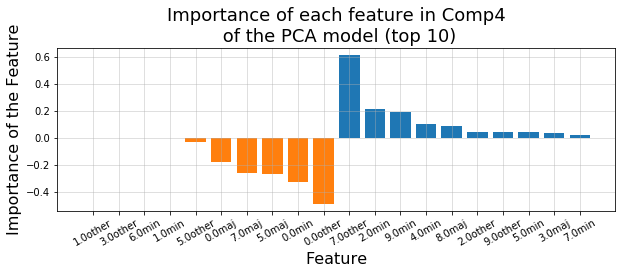

In [269]:
for i in range(1,5):
    InspectWeightVector(weights = model_pca.components_, 
                        pc = i, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'PCA')

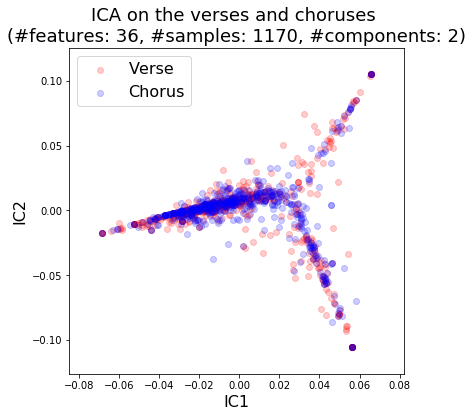

In [292]:
model_ica = FastICA_visualization(df_verse = df_bow_verse_agg,
                                  df_chorus = df_bow_chorus_agg,
                                  vocab = features_agg, 
                                  n_comps = 2)

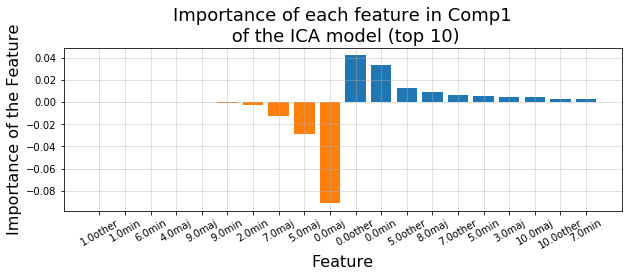

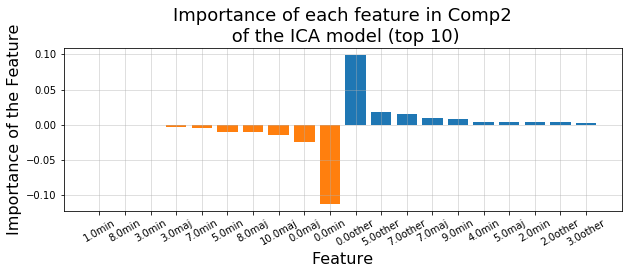

In [286]:
for i in range(1,3):
    InspectWeightVector(weights = model_ica.components_, 
                        pc = i, 
                        features = features_agg, 
                        n_weights = 10, 
                        model_name = 'ICA')

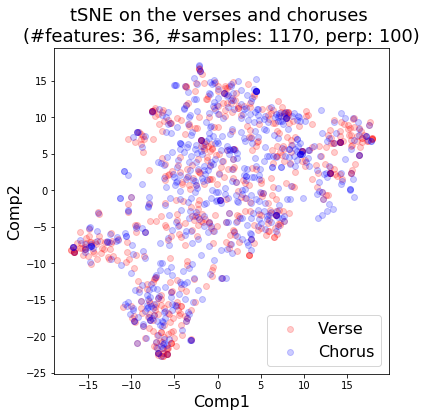

In [256]:
TSNE_visualization(df_verse = df_bow_verse_agg, 
                   df_chorus = df_bow_chorus_agg, 
                   vocab = features_agg,  
                   perplexity = 100)

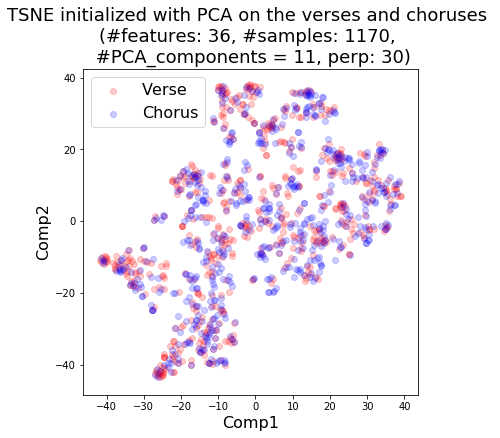

In [257]:
TSNE_PCAinit(df_verse = df_bow_verse_agg, 
             df_chorus = df_bow_chorus_agg,
             vocab = features_agg,
             pca_comps = 11,
             perplexity = 30)

# Discussion of the results